<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.utils import resample

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Данные представлены 14 признаками, три из них являются категориальными:

 - Фамилия `Surname`
 - Страна проживания `Geography`
 - Пол `Gender`

In [3]:
print('Количество положительных и отрицательных значений целевого признака',df.value_counts('Exited'))
print('Доля класс 1 в целевом признаке Exited',df['Exited'].mean())
print('Количество значений класса 0 в целевом признаке певышает класс 1 в',df['Exited'][df.Exited == 0].count() / df['Exited'][df.Exited == 1].count(),'раз')

Количество положительных и отрицательных значений целевого признака Exited
0    7963
1    2037
dtype: int64
Доля класс 1 в целевом признаке Exited 0.2037
Количество значений класса 0 в целевом признаке певышает класс 1 в 3.9091801669121256 раз


In [4]:
print('Количество пропусков признака Tenure:',df['Tenure'].isna().sum())

Количество пропусков признака Tenure: 909


In [5]:
df.corr()['Tenure']

RowNumber         -0.007322
CustomerId        -0.021418
CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
Name: Tenure, dtype: float64

Признак `Tenure` (сколько лет человек является клиентом банка) имеет 909 пропусков. Также данный признак не коррелирует с другими признакими, что не дает возможности восполнить пропуски данных.

Также стоит отметить, что соотношение между положительными и отрицательными ответами для целевого признака `Exited` в строках с пропусками данных такое же как для основной выборки.

Пропуски в данных не позволяют построить модель, поэтому удалим эти данные. 

In [6]:
print(df[df.Tenure.isna()].value_counts('Exited'))
print('Доля отрицательных ответов целевого признака для пропущенных данных признака "Tenure":',df[df.Tenure.isna()].mean()['Exited'])

Exited
0    726
1    183
dtype: int64
Доля отрицательных ответов целевого признака для пропущенных данных признака "Tenure": 0.20132013201320131


In [7]:
df.dropna(inplace=True)

Признаки `RowNumber`, `CustomerId` и `Surname` являются идентификаторами отдельных персоналий в данных и не влияют на целевой
признак. Поэтому, уберем из рассмотрения эти данные.

In [8]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [10]:
#sns.pairplot(df, hue='Exited')
plt.show()

Как видно из графиков выше, рассматриваемые признаки не имееют явной зависимости между друг другом.

## Исследование задачи

Подготовим данные для обучения моделей из следующего соотношения выборок тренировочная 60%, тестовая 20%, валидационная 20%.

Преобразуем дата фрейм методом `One-Hot Encoding`.

In [11]:
df_ohe = pd.get_dummies(df, drop_first=True)

X = df_ohe.drop('Exited', axis=1)
y = df_ohe['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y, shuffle=True)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=39)

print('Размеры тренировочной, валидационной и тестовой выборок:'
      ,X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)
print('Значения целевого признака тренировочной выборки:')
print(y_train.value_counts())
print('Значения целевого признака валидационной выборки:')
print(y_valid.value_counts())
print('Значения целевого признака тестовой выборки:')
print(y_test.value_counts())

Размеры тренировочной, валидационной и тестовой выборок: (5454, 11) (1818, 11) (1819, 11) (5454,) (1818,) (1819,)
Значения целевого признака тренировочной выборки:
0    4336
1    1118
Name: Exited, dtype: int64
Значения целевого признака валидационной выборки:
0    1453
1     365
Name: Exited, dtype: int64
Значения целевого признака тестовой выборки:
0    1448
1     371
Name: Exited, dtype: int64


In [12]:
print(X_train.dtypes)

CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
column_names = ['CreditScore',
                'Age',
                'Tenure',
                'Balance',
                'NumOfProducts',
                'HasCrCard',
                'IsActiveMember',
                'EstimatedSalary',
                'Geography_Germany',
                'Geography_Spain',
                'Gender_Male']

X_train = pd.DataFrame(data=X_train, columns=column_names,index=y_train.index)
X_valid = pd.DataFrame(data=X_valid, columns=column_names,index=y_valid.index)
X_test = pd.DataFrame(data=X_test, columns=column_names,index=y_test.index)

Обучим модель "Дерева принятия решений". Рассмотрим ее как базовый вариант, который работает относительно быстро.

In [14]:
dtc = DecisionTreeClassifier(random_state=39)
dtc.fit(X_train,y_train)

print('Точность модели дерева принятий решений:',dtc.score(X_valid,y_valid))
print('Доля отрицательны ответов в целевом признаке:',1 - df_ohe['Exited'].mean())

Точность модели дерева принятий решений: 0.7915291529152916
Доля отрицательны ответов в целевом признаке: 0.7960620393796062


Как видно из представленных значений выше, модель дает низкую точность. Значение ниже, чем вероятность ответить правильно, проверяя каждый раз один и тот же ответ.

Проверим как точно модель предсказывает целевой признак. Построим матрицу ошибок.

In [15]:
dtc_predic = dtc.predict(X_valid)

print('Матрица ошибок:')
display(confusion_matrix(y_valid, dtc_predic))
print('F1-мера:',f1_score(dtc_predic,y_valid))

Матрица ошибок:


array([[1263,  190],
       [ 189,  176]])

F1-мера: 0.48153214774281805


Количество ошибочных положительных ответов превышает число верно определенных. Также значение F1-меры ниже 0,5.

Качество модели низкое. 

Обучим модель классификатора "Случайного леса" и сравним результат с предварительной моделью "Дерева принятия решений".

In [16]:
rfc = RandomForestClassifier(random_state=39)
rfc.fit(X_train,y_train)
rfc_predic = rfc.predict(X_valid)

print('Точность модели случайного леса:',rfc.score(X_valid,y_valid),'\n')
print('Матрица ошибок:')
display(confusion_matrix(y_valid, rfc_predic))
print('F1-мера:',f1_score(rfc_predic,y_valid))

Точность модели случайного леса: 0.8690869086908691 

Матрица ошибок:


array([[1400,   53],
       [ 185,  180]])

F1-мера: 0.6020066889632107


Как видим из полученных результатов качество работы модели "Случайного леса" значительно выше. Величина метрики выше целевого показателя (0,59).<br>

Рассмотрим также классификатор <code>Support Vectort Machines</code>

In [17]:
svm = SVC(random_state=39,probability=True)
svm.fit(X_train,y_train)
svm_predic = svm.predict(X_valid)

print('Точность модели SVM:',svm.score(X_valid,y_valid),'\n')
print('Матрица ошибок:')
display(confusion_matrix(y_valid, svm_predic))
print('F1-мера:',f1_score(svm_predic,y_valid))

Точность модели SVM: 0.8602860286028603 

Матрица ошибок:


array([[1417,   36],
       [ 218,  147]])

F1-мера: 0.5364963503649636


Модель классификатора SVM показывает результаты выше, чем дерево принятия решений, но ниже случайного леса.

Создадим функцию оценки метрик для исследуемых моделей, а также датафрейм результатов.

In [18]:
result_df = pd.DataFrame(columns=['method','model_name','score','f1','auc_roc'])

#Функция определения значений метрик 
# model - имя модлели
# sample - тип проверочной выборки valid / test

def metric(method, model, sample):
    
    if sample == 'valid':
        X = X_valid
        y = y_valid
    else:
        X = X_test
        y = y_test 
        
    probability = model.predict_proba(X)[:, 1]
    r_a_res = roc_auc_score(y, probability).round(3)
    acc_res = model.score(X, y).round(3)
    f1_res = f1_score(model.predict(X), y).round(3)
    model_name = type(model).__name__

    #добавляем результаты в общий датафрейм результатов
    result_df.loc[len(result_df.index)] = [method, model_name, acc_res, f1_res, r_a_res] 
    
    return print('Модель:',model,'\n'
                'Точность:',acc_res,'\n'
                'F1-мера:',f1_res,'\n'
                'AUC ROC:',r_a_res,'\n')

models = [dtc,rfc,svm]

for mod in models: metric('base_case', mod, 'valid')

display(result_df)

Модель: DecisionTreeClassifier(random_state=39) 
Точность: 0.792 
F1-мера: 0.482 
AUC ROC: 0.676 

Модель: RandomForestClassifier(random_state=39) 
Точность: 0.869 
F1-мера: 0.602 
AUC ROC: 0.859 

Модель: SVC(probability=True, random_state=39) 
Точность: 0.86 
F1-мера: 0.536 
AUC ROC: 0.833 



,method,model_name,score,f1,auc_roc
0,base_case,DecisionTreeClassifier,0.792,0.482,0.676
1,base_case,RandomForestClassifier,0.869,0.602,0.859
2,base_case,SVC,0.860,0.536,0.833


Выше приведены значение метрик для исследуюмых моделей без балансировки классов.<br>
Как видно результат модели случайного леса являются лучшим среди остальных.

## Борьба с дисбалансом

С целью устранения дисбаланса классов были выбраны следующие методики:
 - Балансировка веса классов встроенным параметром моделей <code>class_weight='balanced'</code>
 - Увеличение количества положительных значений целевого признака в тренировочной выборке `Upsampling`

Попробуем сбалансировать классы добавив параметр балансировки весов для классов `class_weight`.

In [19]:
dtc_w = DecisionTreeClassifier(class_weight='balanced', random_state=39)
rfc_w = RandomForestClassifier(class_weight='balanced', random_state=39)
svm_w = SVC(class_weight='balanced', random_state=39,probability=True)
dtc_w.fit(X_train,y_train)
rfc_w.fit(X_train,y_train)
svm_w.fit(X_train,y_train)

models_w = [dtc_w,rfc_w,svm_w]

for mod_w in models_w: metric('class_weight', mod_w, 'valid')

display(result_df)

Модель: DecisionTreeClassifier(class_weight='balanced', random_state=39) 
Точность: 0.806 
F1-мера: 0.512 
AUC ROC: 0.694 

Модель: RandomForestClassifier(class_weight='balanced', random_state=39) 
Точность: 0.866 
F1-мера: 0.579 
AUC ROC: 0.857 

Модель: SVC(class_weight='balanced', probability=True, random_state=39) 
Точность: 0.795 
F1-мера: 0.594 
AUC ROC: 0.851 



,method,model_name,score,f1,auc_roc
0,base_case,DecisionTreeClassifier,0.792,0.482,0.676
1,base_case,RandomForestClassifier,0.869,0.602,0.859
2,base_case,SVC,0.860,0.536,0.833
3,class_weight,DecisionTreeClassifier,0.806,0.512,0.694
4,class_weight,RandomForestClassifier,0.866,0.579,0.857
5,class_weight,SVC,0.795,0.594,0.851


Модели Дерева решений и Структурированных векторов улучшили результаты с примененным параметром веса классов. Модель Случайного леса наоборот показала более низкий результат. Значение метрики F1-мера у случайного леса стала ниже Структурированных векторов.

Воспользуемся методом увеличения количества положительных значений целевого признака в выборке `Upsampling`.

In [20]:
print('Соотношение значений целевого признака "Exited" в тренировочной выборке:')
print(y_train.value_counts())

X_major = X_train[y_train == 0]
X_minor = X_train[y_train == 1]

y_major = y_train[y_train == 0]
y_minor = y_train[y_train == 1]

X_upsample = resample(X_minor, replace=True, n_samples=len(X_train), random_state=39)
y_upsample = resample(y_minor, replace=True, n_samples=len(X_train), random_state=39)

X_sample = pd.concat([X_major, X_upsample])
y_sample = pd.concat([y_major, y_upsample])

print('Соотношение значений целевого признака "Exited" в тренировочной выборке после устранения дисбаланса:')
print(y_sample.value_counts())

Соотношение значений целевого признака "Exited" в тренировочной выборке:
0    4336
1    1118
Name: Exited, dtype: int64
Соотношение значений целевого признака "Exited" в тренировочной выборке после устранения дисбаланса:
1    5454
0    4336
Name: Exited, dtype: int64


Обучим модели на полученных выборках и сравним результаты.

In [21]:
dtc.fit(X_sample,y_sample)
rfc.fit(X_sample,y_sample)
svm.fit(X_sample,y_sample)

for mod in models: metric('upsample', mod, 'valid')

display(result_df)

Модель: DecisionTreeClassifier(random_state=39) 
Точность: 0.801 
F1-мера: 0.49 
AUC ROC: 0.68 

Модель: RandomForestClassifier(random_state=39) 
Точность: 0.855 
F1-мера: 0.604 
AUC ROC: 0.851 

Модель: SVC(probability=True, random_state=39) 
Точность: 0.767 
F1-мера: 0.577 
AUC ROC: 0.844 



,method,model_name,score,f1,auc_roc
0,base_case,DecisionTreeClassifier,0.792,0.482,0.676
1,base_case,RandomForestClassifier,0.869,0.602,0.859
2,base_case,SVC,0.860,0.536,0.833
3,class_weight,DecisionTreeClassifier,0.806,0.512,0.694
4,class_weight,RandomForestClassifier,0.866,0.579,0.857
5,class_weight,SVC,0.795,0.594,0.851
6,upsample,DecisionTreeClassifier,0.801,0.490,0.680
7,upsample,RandomForestClassifier,0.855,0.604,0.851
8,upsample,SVC,0.767,0.577,0.844


Модель Дерева показала результаты ниже в сравнение с предыдущим вариантом борьбы с дисбалансом.<br>
Модель Леса демонстрирует наивысший результат метрики F1-мера, метрика AUC ROC незначительно ниже в сравнение с другим подходом и базовой моделью.<br>
Модель Векторов показалу результаты ниже в сравнение с предыдущим подходом борьбы с дисбалансом.

Как результат в дальнейшем исследование будем применять различные варианты борьбы с дисбалансом для каждой модели:

 - Модель Дерева и Векторов обучим с применением параметра <code>class_weight='balanced'</code>
 - Для модели Леса применим метод `upsampling` в дополнение к параметру баланса классов <code>class_weight</code>.

Подберем оптимальные гиперпараметры для исследуемых моделей по средствам класса `GridSearchCV`.

In [22]:
%%time

params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random'],
    'class_weight': ['balanced']
}

grid_dtc = GridSearchCV(dtc_w, params, cv=5, n_jobs=5)
grid_dtc.fit(X_train, y_train)

grid_dtc.best_params_

CPU times: user 1.05 s, sys: 752 ms, total: 1.8 s
Wall time: 23.5 s


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'splitter': 'best'}

In [23]:
%%time

parametrs = { 'class_weight': ['balanced'],
              'n_estimators': range (40, 101, 10),
              'max_depth': range (10, 13, 1),
              'min_samples_leaf': range (1, 3),
              'min_samples_split': range (2, 3, 1) }

grid_rfc = GridSearchCV(rfc, parametrs, cv=5, n_jobs=5)
grid_rfc.fit(X_sample, y_sample)

grid_rfc.best_params_

CPU times: user 1.04 s, sys: 540 ms, total: 1.58 s
Wall time: 2min 33s


{'class_weight': 'balanced',
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [24]:
%%time

tuned_parameters = {'kernel': ['rbf'],
                    'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                    'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}

grid_svm = GridSearchCV(svm_w, tuned_parameters, cv=5)
grid_svm.fit(X_train, y_train)

grid_svm.best_params_

CPU times: user 13min 52s, sys: 858 ms, total: 13min 53s
Wall time: 13min 56s


{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Обучим модели с полученными оптимальными параметрами.

In [25]:
dtc_opt = DecisionTreeClassifier(class_weight='balanced',
                                 criterion='gini',
                                 max_depth=None,
                                 max_features=None,
                                 splitter='best',
                                 random_state=39)

rfc_opt = RandomForestClassifier(max_depth=12,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=50,
                                 class_weight='balanced',
                                 random_state=39)

svm_opt = SVC(C=1000,
              gamma=.01,
              kernel='rbf',
              class_weight='balanced',
              random_state=39,
              probability=True)


dtc_opt.fit(X_train,y_train)
rfc_opt.fit(X_sample,y_sample)
svm_opt.fit(X_train,y_train)

models_opt = [dtc_opt,rfc_opt,svm_w]

for mod in models_opt: metric('optim', mod, 'valid')

display(result_df)

Модель: DecisionTreeClassifier(class_weight='balanced', random_state=39) 
Точность: 0.806 
F1-мера: 0.512 
AUC ROC: 0.694 

Модель: RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=50,
                       random_state=39) 
Точность: 0.85 
F1-мера: 0.63 
AUC ROC: 0.861 

Модель: SVC(class_weight='balanced', probability=True, random_state=39) 
Точность: 0.795 
F1-мера: 0.594 
AUC ROC: 0.851 



,method,model_name,score,f1,auc_roc
0,base_case,DecisionTreeClassifier,0.792,0.482,0.676
1,base_case,RandomForestClassifier,0.869,0.602,0.859
2,base_case,SVC,0.860,0.536,0.833
3,class_weight,DecisionTreeClassifier,0.806,0.512,0.694
4,class_weight,RandomForestClassifier,0.866,0.579,0.857
5,class_weight,SVC,0.795,0.594,0.851
6,upsample,DecisionTreeClassifier,0.801,0.490,0.680
7,upsample,RandomForestClassifier,0.855,0.604,0.851
8,upsample,SVC,0.767,0.577,0.844
9,optim,DecisionTreeClassifier,0.806,0.512,0.694


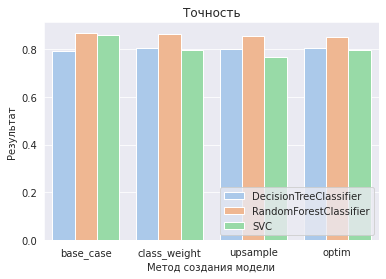

In [26]:
sns.set_palette('pastel')
sns.set_style('darkgrid')
sns.barplot(data=result_df,x='method',y='score',hue='model_name')
plt.title('Точность')
plt.xlabel('Метод создания модели')
plt.ylabel('Результат')
plt.legend(loc='lower right')
plt.show()

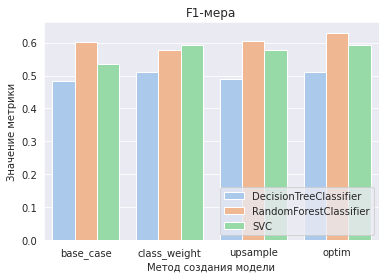

In [27]:
sns.barplot(data=result_df,x='method',y='f1',hue='model_name')
plt.title('F1-мера')
plt.xlabel('Метод создания модели')
plt.ylabel('Значение метрики')
plt.legend(loc='lower right')
plt.show()

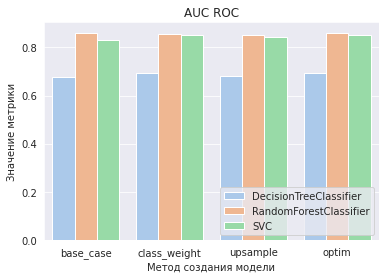

In [28]:
sns.barplot(data=result_df,x='method',y='auc_roc',hue='model_name')
plt.title('AUC ROC')
plt.xlabel('Метод создания модели')
plt.ylabel('Значение метрики')
plt.legend(loc='lower right')
plt.show()

Лучший результат показывает модель Случайного леса с оптимальными параметрами.<br>
Метрики модели Случайного леса с оптимальными параметрами F1-мера и AUC ROC имеют наивысший результат среди других моделей.<br>
Результаты модели Структурированных векторов близки к Случайному лесу, кроме F1-меры.<br>
Выберем эти две модели для тестирования.

## Тестирование модели

Проверим выбранные модели на тестовой выборке.

In [29]:
models_fin = [rfc_opt,svm_opt]

for mod in models_fin: metric('final', mod, 'test')

final_res = result_df[result_df.method == 'final']

display(final_res)

Модель: RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=50,
                       random_state=39) 
Точность: 0.847 
F1-мера: 0.624 
AUC ROC: 0.862 

Модель: SVC(C=1000, class_weight='balanced', gamma=0.01, probability=True,
    random_state=39) 
Точность: 0.778 
F1-мера: 0.582 
AUC ROC: 0.848 



,method,model_name,score,f1,auc_roc
12,final,RandomForestClassifier,0.847,0.624,0.862
13,final,SVC,0.778,0.582,0.848


In [30]:
predicted_test = rfc_opt.predict(X_test)
print(classification_report(y_test,predicted_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1448
           1       0.63      0.62      0.62       371

    accuracy                           0.85      1819
   macro avg       0.76      0.76      0.76      1819
weighted avg       0.85      0.85      0.85      1819



In [31]:
predicted_test = svm_opt.predict(X_test)
print(classification_report(y_test,predicted_test))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1448
           1       0.47      0.75      0.58       371

    accuracy                           0.78      1819
   macro avg       0.70      0.77      0.72      1819
weighted avg       0.83      0.78      0.79      1819



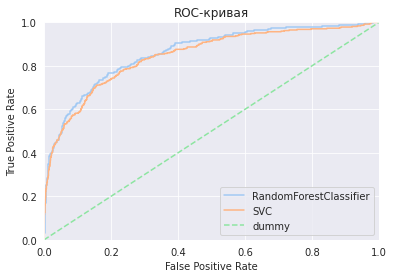

In [32]:
prob_one_test_rfc = rfc_opt.predict_proba(X_test)[:, 1]
prob_one_test_svm = svm_opt.predict_proba(X_test)[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_test,prob_one_test_rfc)
fpr2, tpr2, thresholds2 = roc_curve(y_test,prob_one_test_svm)

plt.figure()

plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)

plt.plot([0,1], [0,1], linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend([type(rfc_opt).__name__,type(svm_opt).__name__,'dummy'])

plt.title("ROC-кривая")
plt.show()

Модель случайного леса с найденными оптимальными параметрами, обученая на баласированной тренировочной выборке безоговорочный лидер по результатам исследования.

Все метрики, включая площадь под ROC кривой, выше остальных рассмотренных моделей.

<h2> Результат исследования <a class="tocSkip"> </h2>

На начальном этапе исследования данных были выявлены пропуске данных в признаке `Tenure`. Данные с пропусками были удалены из рассмотрения, так как не повлияли на соотношение значений целевого признака `Exited`.
    
Данные были разделены на три выборки тренировочную, валидационную и тестовую в соотношении `60 / 20 / 20`.

Был определен дисбаланс классов, влияющий на результаты обучения моделей.<br>
Методами борьбы с дисбаласом классов были выбраны встроенный параметр `class_weight` моделей, а также увеличение положительных ответов в тренировочной выборке `upsampling`.<br>
    
Также были определены оптимальные параметры моделей классом `GridSearchCV`
    
На каждом этапе отмечались следующие результаты:
 - Точность `score`
 - F1-мера `f1`
 - Площадь под ROC кривой `auc_roc`

На всех этапах исследования классификатор на основе модели "Случайного леса" показывает лучшие результаты рассматриваемых метрик.
    
В результате исследования была получена модель со следующими показателями метрик для тестовых  (валидационных) данных:
    
 - F1-мера - 0.62 (0.63)
 - AUC-ROC - 0.86 (0.86)
    
Параметры лучшей модели следующие:<br>
<code>RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=50,random_state=39)</code>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*